In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "CRPS"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_CRPS': 'GPBoost'

}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "CRPS"]
df = df[df["split_method"] == "random_split"]

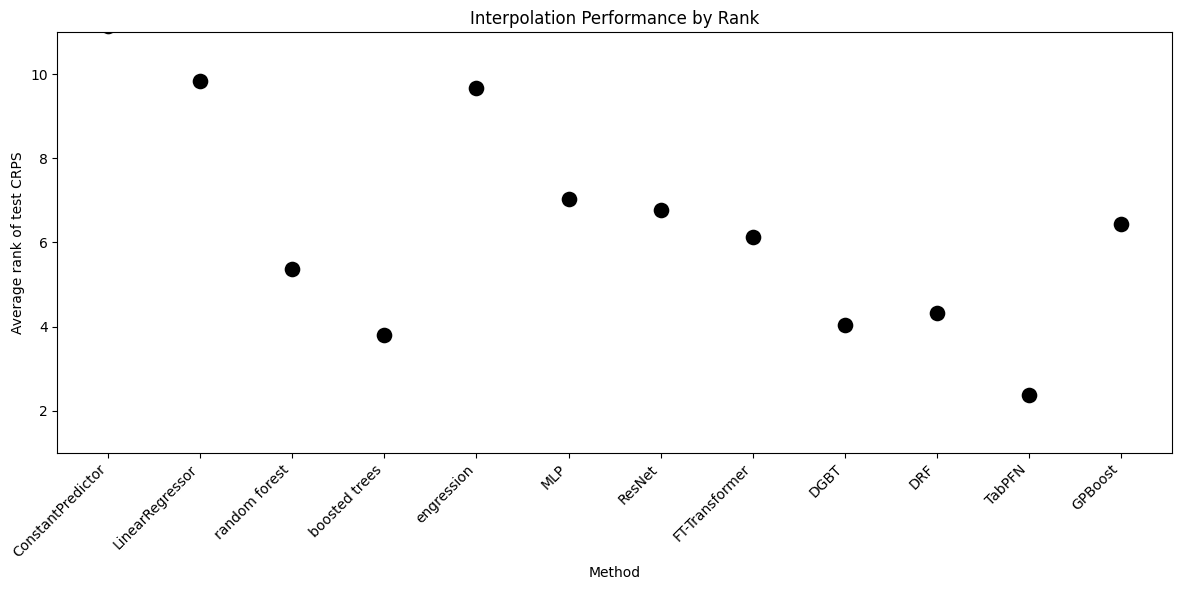

In [3]:
df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor', 'LinearRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'DGBT':                 'DGBT',
    'DRF':                  'DRF',
    'TabPFNRegressor':     'TabPFN',
    'GPBoost_CRPS':         'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average rank of test CRPS')
plt.xlabel('Method')
plt.title('Interpolation Performance by Rank')
plt.ylim(1, 11)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_rank_IP_CRPS.png', bbox_inches='tight')
plt.show()
